In [1]:
# Dependencias tensorflow
import tensorflow as tf
from tensorflow.keras import layers, models
import tensorflow.keras.backend as K

# Dependencia para trabajar con archivos ZIP
import zipfile

# Otras liberías
import numpy as np
import matplotlib.pyplot as plt
import os
import glob
from pathlib import Path
import pandas as pd
import seaborn as sns

In [2]:
N_ROWS = 256
N_COLS = 256
N_LABELS = 1

def read_image(image_path, mask_path):
    
    # Leemos la imagen del directorio
    image = tf.io.read_file(image_path)
    # Decodificamos la imagen en función del tipo de codificación (PNG) en nuestro caso
    image = tf.image.decode_png(image, channels=1)
    # Convertimos la imagen a float32 --> Este método al mismo tiempo, al especificarle tipo de dato float hace el escalado a [0,1]
    image = tf.image.convert_image_dtype(image, tf.float32)
    # Redimensionamos la imagen al tamaño deseado
    image = tf.image.resize(image, (N_ROWS, N_COLS), method='nearest')

    # Leemos la máscara del directorio
    mask = tf.io.read_file(mask_path)
    # Decodificamos la imagen en función del tipo de codificación (PNG) en nuestro caso
    mask = tf.image.decode_png(mask, channels=1)

    # Las máscaras están guardadas de manera que el número de la etiqueta (0-12) se encuentra en el primer canal
    # Por lo tanto, nos quedamos con el valor máximo de cada canal para crear una matriz de tamaño [FILAS, COLUMNAS, 1]
    print(mask.shape)
    #mask = tf.math.reduce_max(mask.numpy, axis=-1, keepdims=True)
    mask /= 255
    mask = tf.cast(mask, tf.uint8)
    
    # Redimensionamos la imagen al tamaño deseado
    mask = tf.image.resize(mask, (N_ROWS, N_COLS), method='nearest')
    # Eliminamos el último canal para quedarnos con matriz [FILAS, COLUMNAS]
    #mask = tf.squeeze(mask, axis=-1)
    # Codificamos matriz a OneHot
    #mask = tf.one_hot(tf.cast(mask, tf.int32), N_LABELS)
    
    return image, mask

In [3]:
def dataset_generator(image_paths, mask_paths, buffer_size, batch_size):
    
    image_list = tf.constant(image_paths) 
    mask_list = tf.constant(mask_paths)

    print(image_list)
    print(mask_list)
    dataset = tf.data.Dataset.from_tensor_slices((image_list, mask_list))
    # A cada elemento del dataset (directorios imagenes y máscaras) les aplicamos el método read_image
    dataset = dataset.map(read_image, num_parallel_calls=tf.data.AUTOTUNE)
    dataset = dataset.cache().shuffle(buffer_size).batch(batch_size)
    
    return dataset

In [4]:
ruta = Path('lung_segmentation')

train_f = ruta / 'train'

test_f = ruta / 'test'

val_f = ruta / 'validation'

img_dir_train_frontal = train_f / 'images'
mask_dir_train_frontal = train_f / 'masks'

train_image_paths = glob.glob(os.path.join(img_dir_train_frontal, '*.png'))

train_mask_paths = glob.glob(os.path.join(mask_dir_train_frontal, '*.png'))

img_dir_val_frontal = val_f / 'images'
mask_dir_val_frontal = val_f / 'masks'

val_image_paths = glob.glob(os.path.join(img_dir_val_frontal, '*.png'))

val_mask_paths = glob.glob(os.path.join(mask_dir_val_frontal, '*.png'))

img_dir_test_frontal = test_f / 'images'
mask_dir_test_frontal = test_f / 'masks'

test_image_paths = glob.glob(os.path.join(img_dir_test_frontal, '*.png'))

test_mask_paths = glob.glob(os.path.join(mask_dir_test_frontal, '*.png'))

print('Número de imágenes de entrenamiento: ', len(train_image_paths))
print('Número de imágenes de validación: ', len(val_image_paths))
print('Número de imágenes de test: ', len(test_image_paths))

Número de imágenes de entrenamiento:  2000
Número de imágenes de validación:  319
Número de imágenes de test:  319


In [5]:
BATCH_SIZE = 32
BUFFER_SIZE = 500

train_dataset = dataset_generator(train_image_paths, train_mask_paths, BUFFER_SIZE, BATCH_SIZE)
validation_dataset = dataset_generator(val_image_paths, val_mask_paths, BUFFER_SIZE, BATCH_SIZE)

tf.Tensor(
[b'lung_segmentation\\train\\images\\0019_2.png'
 b'lung_segmentation\\train\\images\\0019_3.png'
 b'lung_segmentation\\train\\images\\0019_4.png' ...
 b'lung_segmentation\\train\\images\\NIH_0078.png'
 b'lung_segmentation\\train\\images\\NIH_0079.png'
 b'lung_segmentation\\train\\images\\NIH_0080.png'], shape=(2000,), dtype=string)
tf.Tensor(
[b'lung_segmentation\\train\\masks\\0019_2.png'
 b'lung_segmentation\\train\\masks\\0019_3.png'
 b'lung_segmentation\\train\\masks\\0019_4.png' ...
 b'lung_segmentation\\train\\masks\\NIH_0078_mask.png'
 b'lung_segmentation\\train\\masks\\NIH_0079_mask.png'
 b'lung_segmentation\\train\\masks\\NIH_0080_mask.png'], shape=(2000,), dtype=string)
(None, None, 1)
tf.Tensor(
[b'lung_segmentation\\validation\\images\\0001_0.png'
 b'lung_segmentation\\validation\\images\\0001_1.png'
 b'lung_segmentation\\validation\\images\\0001_2.png'
 b'lung_segmentation\\validation\\images\\0001_3.png'
 b'lung_segmentation\\validation\\images\\0001_4.png'
 b

In [24]:
test_dataset = dataset_generator(test_image_paths, test_mask_paths, BUFFER_SIZE, BATCH_SIZE)

tf.Tensor(
[b'lung_segmentation\\test\\images\\0010_1.png'
 b'lung_segmentation\\test\\images\\0010_2.png'
 b'lung_segmentation\\test\\images\\0010_3.png'
 b'lung_segmentation\\test\\images\\0010_4.png'
 b'lung_segmentation\\test\\images\\0010_5.png'
 b'lung_segmentation\\test\\images\\0011_0.png'
 b'lung_segmentation\\test\\images\\0011_1.png'
 b'lung_segmentation\\test\\images\\0011_2.png'
 b'lung_segmentation\\test\\images\\0011_3.png'
 b'lung_segmentation\\test\\images\\0011_4.png'
 b'lung_segmentation\\test\\images\\0011_5.png'
 b'lung_segmentation\\test\\images\\0012_0.png'
 b'lung_segmentation\\test\\images\\0012_1.png'
 b'lung_segmentation\\test\\images\\0012_2.png'
 b'lung_segmentation\\test\\images\\0012_3.png'
 b'lung_segmentation\\test\\images\\0012_4.png'
 b'lung_segmentation\\test\\images\\0012_5.png'
 b'lung_segmentation\\test\\images\\0013_0.png'
 b'lung_segmentation\\test\\images\\0013_1.png'
 b'lung_segmentation\\test\\images\\0013_2.png'
 b'lung_segmentation\\test\\i

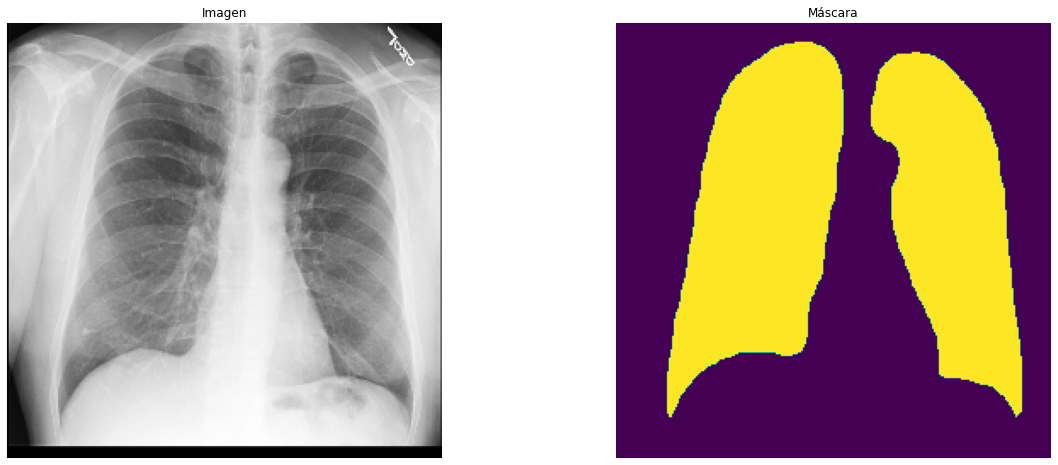

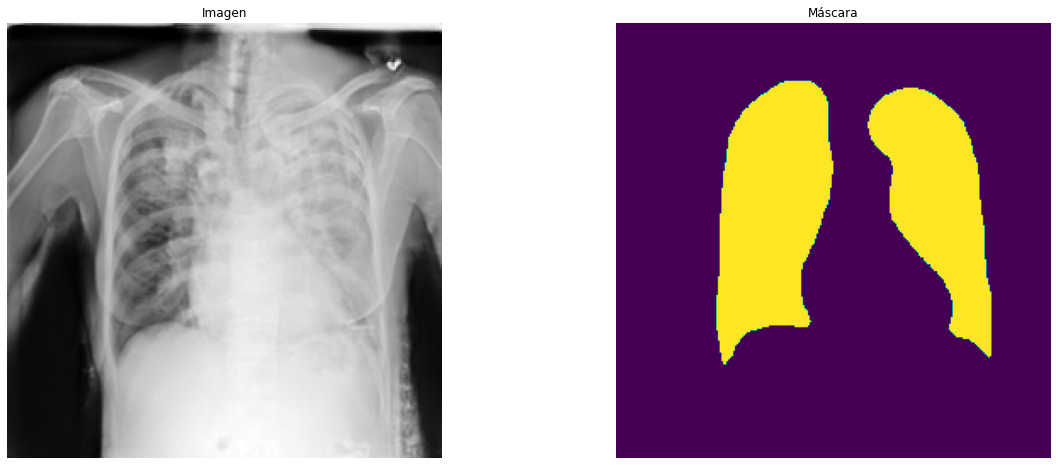

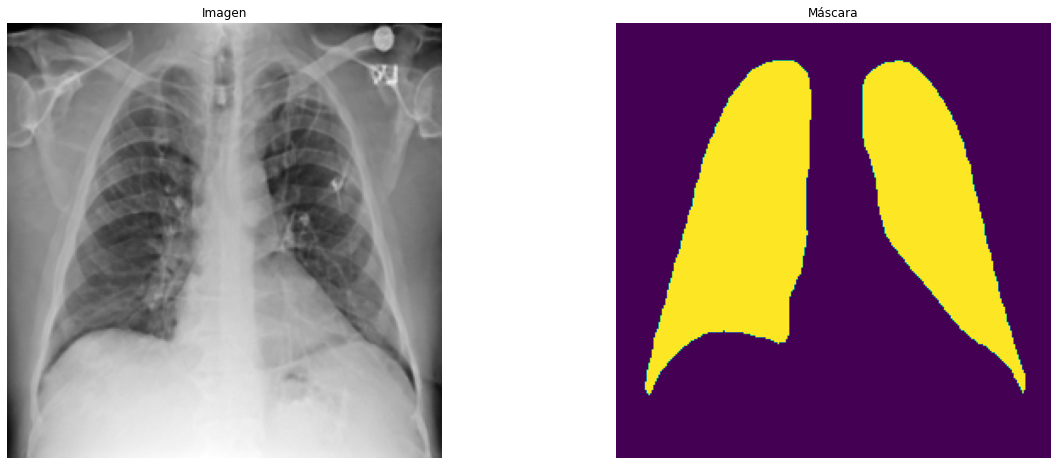

In [6]:
for images, masks in train_dataset.take(1):
  for i in range(3):
    image, mask = images[i], masks[i]
    plt.figure(figsize=(20,8))
    plt.subplot(121)
    plt.imshow(image, 'gray')
    plt.axis('off')
    plt.title('Imagen')
    plt.subplot(122)
    plt.imshow(mask)
    plt.axis('off')
    plt.title('Máscara')
    plt.show()

In [7]:
IMAGE_SHAPE = (N_ROWS, N_COLS, 1)
ACTIVATION = 'sigmoid'

def get_unet():
    # Fase Codificación
    inputs = layers.Input(IMAGE_SHAPE)
    conv1 = layers.Conv2D(32, (3, 3), padding='same')(inputs)
    conv1 = layers.BatchNormalization()(conv1)
    conv1 = layers.Activation('relu')(conv1)
    conv1 = layers.Conv2D(32, (3, 3), padding='same')(conv1)
    conv1 = layers.BatchNormalization()(conv1)
    conv1 = layers.Activation('relu')(conv1)
    pool1 = layers.MaxPooling2D(pool_size=(2, 2))(conv1)

    conv2 = layers.Conv2D(64, (3, 3), padding='same')(pool1)
    conv2 = layers.BatchNormalization()(conv2)
    conv2 = layers.Activation('relu')(conv2)
    conv2 = layers.Conv2D(64, (3, 3), padding='same')(conv2)
    conv2 = layers.BatchNormalization()(conv2)
    conv2 = layers.Activation('relu')(conv2)
    pool2 = layers.MaxPooling2D(pool_size=(2, 2))(conv2)

    conv3 = layers.Conv2D(128, (3, 3), padding='same')(pool2)
    conv3 = layers.BatchNormalization()(conv3)
    conv3 = layers.Activation('relu')(conv3)
    conv3 = layers.Conv2D(128, (3, 3), padding='same')(conv3)
    conv3 = layers.BatchNormalization()(conv3)
    conv3 = layers.Activation('relu')(conv3)
    pool3 = layers.MaxPooling2D(pool_size=(2, 2))(conv3)

    conv4 = layers.Conv2D(256, (3, 3), padding='same')(pool3)
    conv4 = layers.BatchNormalization()(conv4)
    conv4 = layers.Activation('relu')(conv4)
    conv4 = layers.Conv2D(256, (3, 3), padding='same')(conv4)
    conv4 = layers.BatchNormalization()(conv4)
    conv4 = layers.Activation('relu')(conv4)
    pool4 = layers.MaxPooling2D(pool_size=(2, 2))(conv4)

    # Fase de decodificación
    conv5 = layers.Conv2D(512, (3, 3), padding='same')(pool4)
    conv5 = layers.BatchNormalization()(conv5)
    conv5 = layers.Activation('relu')(conv5)
    conv5 = layers.Conv2D(512, (3, 3), padding='same')(conv5)
    conv5 = layers.BatchNormalization()(conv5)
    conv5 = layers.Activation('relu')(conv5)

    up6 = layers.concatenate([layers.Conv2DTranspose(256, (2, 2), strides=(2, 2), padding='same')(conv5), conv4], axis=3)
    conv6 = layers.Conv2D(256, (3, 3), padding='same')(up6)
    conv6 = layers.BatchNormalization()(conv6)
    conv6 = layers.Activation('relu')(conv6)
    conv6 = layers.Conv2D(256, (3, 3), padding='same')(conv6)
    conv6 = layers.BatchNormalization()(conv6)
    conv6 = layers.Activation('relu')(conv6)

    up7 = layers.concatenate([layers.Conv2DTranspose(128, (2, 2), strides=(2, 2), padding='same')(conv6), conv3], axis=3)
    conv7 = layers.Conv2D(128, (3, 3), padding='same')(up7)
    conv7 = layers.BatchNormalization()(conv7)
    conv7 = layers.Activation('relu')(conv7)
    conv7 = layers.Conv2D(128, (3, 3), padding='same')(conv7)
    conv7 = layers.BatchNormalization()(conv7)
    conv7 = layers.Activation('relu')(conv7)

    up8 = layers.concatenate([layers.Conv2DTranspose(64, (2, 2), strides=(2, 2), padding='same')(conv7), conv2], axis=3)
    conv8 = layers.Conv2D(64, (3, 3), padding='same')(up8)
    conv8 = layers.BatchNormalization()(conv8)
    conv8 = layers.Activation('relu')(conv8)
    conv8 = layers.Conv2D(64, (3, 3), padding='same')(conv8)
    conv8 = layers.BatchNormalization()(conv8)
    conv8 = layers.Activation('relu')(conv8)

    up9 = layers.concatenate([layers.Conv2DTranspose(32, (2, 2), strides=(2, 2), padding='same')(conv8), conv1], axis=3)
    conv9 = layers.Conv2D(32, (3, 3), padding='same')(up9)
    conv9 = layers.BatchNormalization()(conv9)
    conv9 = layers.Activation('relu')(conv9)
    conv9 = layers.Conv2D(32, (3, 3), padding='same')(conv9)
    conv9 = layers.BatchNormalization()(conv9)
    conv9 = layers.Activation('relu')(conv9)

    out = layers.Conv2D(N_LABELS, (1, 1))(conv9)

    output = layers.Activation(ACTIVATION)(out)

    model = models.Model(inputs=[inputs], outputs=[output])

    return model

In [8]:
model_unet = get_unet()

model_unet.summary()

Model: "model"
__________________________________________________________________________________________________
 Layer (type)                   Output Shape         Param #     Connected to                     
 input_1 (InputLayer)           [(None, 256, 256, 1  0           []                               
                                )]                                                                
                                                                                                  
 conv2d (Conv2D)                (None, 256, 256, 32  320         ['input_1[0][0]']                
                                )                                                                 
                                                                                                  
 batch_normalization (BatchNorm  (None, 256, 256, 32  128        ['conv2d[0][0]']                 
 alization)                     )                                                             

In [9]:
smooth = 1.
def iou(targets, inputs):
    
    inputs = K.flatten(inputs)
    targets = K.flatten(targets)
    
    intersection = K.sum(targets * inputs)
    total = K.sum(targets) + K.sum(inputs)
    union = total - intersection
    
    IoU = (intersection + smooth) / (union + smooth)
    return IoU

In [10]:
model_unet.compile(optimizer='adam', 
                   loss='binary_crossentropy',
                   metrics=['accuracy', iou])

In [11]:
path_models = ruta / 'binary_segmentation' / 'models'
path_experiment =  path_models / 'Train1'
path_experiment.mkdir(exist_ok=True, parents = True)

In [12]:
EPOCHS = 10

model_checkpoint_callback = tf.keras.callbacks.ModelCheckpoint(
    filepath=path_experiment / 'model.h5',
    monitor='val_accuracy',
    mode='max',
    save_best_only=True,
    verbose=1)

history_unet = model_unet.fit(train_dataset,
                              epochs=EPOCHS,
                              steps_per_epoch= int(2000/BATCH_SIZE),   
                              validation_data=validation_dataset,
                              validation_steps = int(319/BATCH_SIZE),
                              callbacks=[model_checkpoint_callback],
                              verbose=1)

np.save(path_experiment / 'history.npy', history_unet.history)

Epoch 1/10
62/62 [==============================] - ETA: 0s - loss: 0.2289 - accuracy: 0.9106 - iou: 0.5976 
Epoch 1: val_accuracy improved from -inf to 0.45070, saving model to lung_segmentation\binary_segmentation\models\Train1\model.h5
62/62 [==============================] - 1836s 30s/step - loss: 0.2289 - accuracy: 0.9106 - iou: 0.5976 - val_loss: 2.4429 - val_accuracy: 0.4507 - val_iou: 0.3199
Epoch 2/10
 1/62 [..............................] - ETA: 14:18 - loss: 0.1104 - accuracy: 0.9632 - iou: 0.7547WARNING:tensorflow:Your input ran out of data; interrupting training. Make sure that your dataset or generator can generate at least `steps_per_epoch * epochs` batches (in this case, 620 batches). You may need to use the repeat() function when building your dataset.

Epoch 2: val_accuracy improved from 0.45070 to 0.49745, saving model to lung_segmentation\binary_segmentation\models\Train1\model.h5
62/62 [==============================] - 87s 1s/step - loss: 0.1104 - accuracy: 0.9632

In [20]:
# Representación de exactitud, coeficiente DICE e IOU en entrenamiento y validación
def show_learning_curves(history):
  plt.figure(figsize=(20,5))
  # Exactitud
  plt.subplot(1, 3, 1)
  plt.plot(history.history['accuracy'], label='Entrenamiento')
  plt.plot(history.history['val_accuracy'], label='Validación')
  plt.xlabel('Época')
  plt.ylabel('Exactitud')
  plt.title('Exactitud')
  plt.ylim([0, 1])
  plt.legend()

  # Intersección sobre la unión
  plt.subplot(1, 3, 3)
  plt.plot(history.history['iou'], label='Entrenamiento')
  plt.plot(history.history['val_iou'], label='Validación')
  plt.xlabel('Época')
  plt.ylabel('IOU')
  plt.title('Intersección sobre la unión')
  plt.ylim([0, 1])
  plt.legend()

In [19]:
history_unet.history

{'loss': [0.22891125082969666, 0.11040309816598892],
 'accuracy': [0.9106286764144897, 0.9632320404052734],
 'iou': [0.5976364016532898, 0.7546970248222351],
 'val_loss': [2.442904233932495, 1.8800455331802368],
 'val_accuracy': [0.4506974220275879, 0.4974462687969208],
 'val_iou': [0.3199450969696045, 0.3354261517524719]}

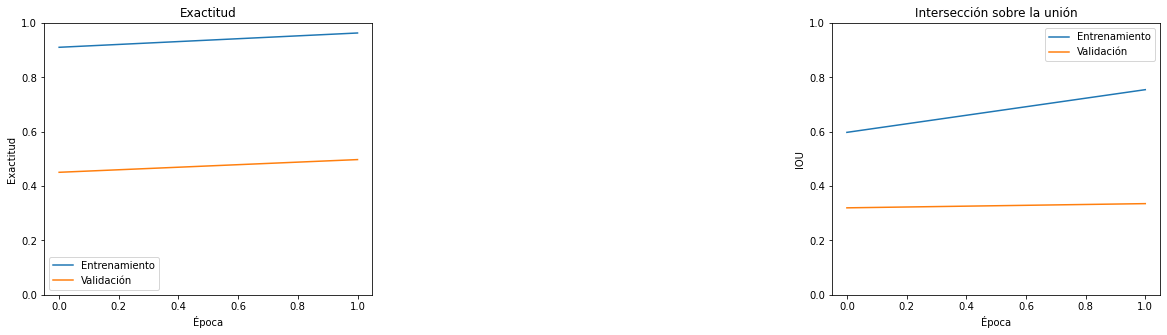

In [21]:
show_learning_curves(history_unet)

# Test

In [22]:
label_names = ['Fondo', 'Pulmones']

In [32]:
def show_prediction(model, test_dataset):
  for images, masks in test_dataset.take(1):
    
    pred_masks = model.predict(images)
    for i in range(3):

      image, mask = images[i], masks[i]
      pred_mask = pred_masks[i]

      plt.figure(figsize=(20,10))
      plt.subplot(131)
      image = (image + 1) / 2.0
      plt.imshow(image, 'gray')
      plt.axis('off')
      plt.title('Imagen')
      plt.subplot(132)
      plt.imshow(mask)
      plt.axis('off')
      plt.title('Máscara real')
      plt.subplot(133)
      plt.imshow(pred_mask)
      plt.axis('off')
      plt.title('Máscara predicha')
      plt.show()

      real_labels = np.unique(mask)
      predicted_labels = np.unique(pred_mask)
      print('Etiquetas máscara real: ', real_labels)
      print('Etiquetas máscara predicha: ', predicted_labels)
      for real_label in real_labels:
        if real_label not in predicted_labels:
          print(f'Clase {label_names[real_label]} ({real_label}) no segmentada.')

1/1 [==============================] - 7s 7s/step


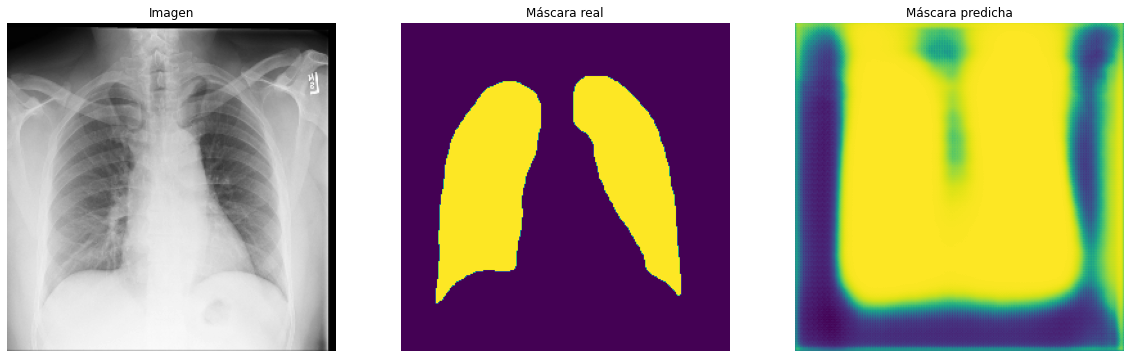

Etiquetas máscara real:  [0 1]
Etiquetas máscara predicha:  [0.09369119 0.09406661 0.09453499 ... 0.9999966  0.99999666 0.9999967 ]
Clase Fondo (0) no segmentada.
Clase Pulmones (1) no segmentada.


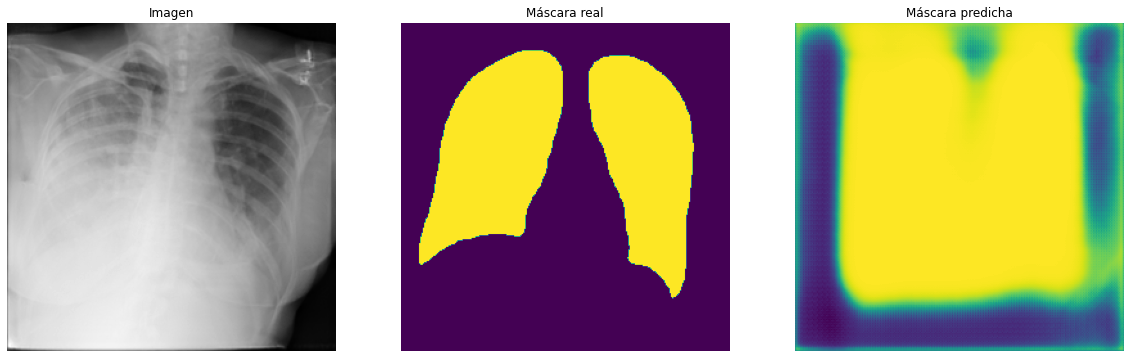

Etiquetas máscara real:  [0 1]
Etiquetas máscara predicha:  [0.09403203 0.09436132 0.09457005 ... 0.9999748  0.9999754  0.9999758 ]
Clase Fondo (0) no segmentada.
Clase Pulmones (1) no segmentada.


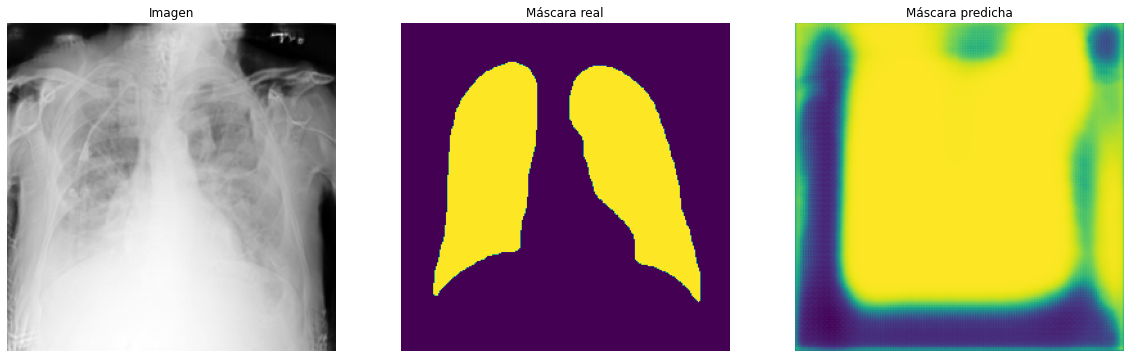

Etiquetas máscara real:  [0 1]
Etiquetas máscara predicha:  [0.0937451  0.09413919 0.09477855 ... 0.99992824 0.9999285  0.9999286 ]
Clase Fondo (0) no segmentada.
Clase Pulmones (1) no segmentada.


In [33]:
show_prediction(model_unet, test_dataset)